# Gradient boosted decision trees on Donors Choose Dataset (NLP)

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

In [54]:
import pandas
data = pandas.read_csv('preprocessed_data.csv', nrows=30000)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

<h4>Preprocessing the 'project_title' column<h4>

In [55]:
data2 = pandas.read_csv('train_data.csv', nrows=30000) #to import 'project_title' column from train_data.csv

In [56]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [58]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [59]:
preprocessed_titles = preprocess_text(data2['project_title'].values)

100%|██████████| 30000/30000 [00:04<00:00, 6067.75it/s]


In [60]:
data['project_title'] = preprocessed_titles

In [61]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [62]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

(20100, 9) (20100,)
(9900, 9) (9900,)


In [63]:
X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,project_title
15931,nv,ms,grades_3_5,0,literacy_language math_science,literature_writing mathematics,my 4th grade students eva wolfe elementary har...,60.97,playing way financial literacy
4747,mo,ms,grades_3_5,0,literacy_language math_science,literacy mathematics,for past 21 years i fortunate fulfill dream cl...,301.51,need poetry travel
523,oh,mrs,grades_prek_2,74,health_sports music_arts,nutritioneducation visualarts,my students nervous trying new foods they want...,77.54,teamwork preschool
18049,va,ms,grades_3_5,14,literacy_language,literacy,i always wonderful group students eager learn ...,170.83,summer school learning fun
18341,fl,ms,grades_6_8,1,appliedlearning math_science,charactereducation mathematics,my students special want learn yet lack necess...,966.28,keystrokes toward discovery


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [64]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_test_project_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_train.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(20100, 1525) (20100,)
(9900, 1525) (9900,)


In [65]:
#please use below code to load glove vectors 
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [66]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [67]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
tfidf_w2v_project_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300)#as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_project_title_train.append(vector)

print(len(tfidf_w2v_project_title_train))
print(len(tfidf_w2v_project_title_train[0]))

from scipy import sparse
tfidf_w2v_project_title_train = sparse.csr_matrix(tfidf_w2v_project_title_train)

100%|██████████| 20100/20100 [00:03<00:00, 5242.83it/s]


20100
300


In [68]:
tfidf_w2v_project_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_project_title_test.append(vector)

print(len(tfidf_w2v_project_title_test))
print(len(tfidf_w2v_project_title_test[0]))
#print(tfidf_w2v_vectors_test[0])

tfidf_w2v_project_title_test = sparse.csr_matrix(tfidf_w2v_project_title_test)

100%|██████████| 9900/9900 [00:02<00:00, 4023.42it/s]


9900
300


In [69]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(20100, 5000) (20100,)
(9900, 5000) (9900,)


In [70]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [71]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300)#as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))
#print(tfidf_w2v_vectors_train[0])

100%|██████████| 20100/20100 [03:58<00:00, 84.28it/s] 

20100
300


In [72]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|██████████| 9900/9900 [01:56<00:00, 85.20it/s] 

9900
300


In [73]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Abhishek
[nltk_data]     Chand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [74]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()

train_sentiment = []
for i in X_train['essay'].values:
    ss = sid.polarity_scores(i)
    a = [ss[k] for k in ss]
    train_sentiment.append(a)

train_sentiment = np.array(train_sentiment)
print(train_sentiment)

[[0.054  0.703  0.243  0.979 ]
 [0.02   0.675  0.305  0.9969]
 [0.095  0.593  0.312  0.9816]
 ...
 [0.03   0.763  0.207  0.979 ]
 [0.035  0.706  0.259  0.9952]
 [0.027  0.733  0.24   0.9867]]


In [75]:
test_sentiment = []
for i in X_test['essay'].values:
    ss = sid.polarity_scores(i)
    a = [ss[k] for k in ss]
    test_sentiment.append(a)

test_sentiment = np.array(test_sentiment)
print(test_sentiment)

[[0.056  0.722  0.222  0.991 ]
 [0.069  0.665  0.266  0.9786]
 [0.044  0.625  0.331  0.992 ]
 ...
 [0.102  0.561  0.337  0.9928]
 [0.059  0.619  0.323  0.9904]
 [0.075  0.736  0.189  0.9772]]


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

response coding for categorical features

In [76]:
def response_table(X,y):
    response_table = {}
    for i in range(len(X)):
        if y[i] == 0:
            if X[i] not in response_table.keys():
                response_table[X[i]] = [1,0]
            else:
                response_table[X[i]][0]+=1
        else:
            if X[i] not in response_table.keys():
                response_table[X[i]] = [0,1]
            else:
                response_table[X[i]][1]+=1
    return response_table

def response_coding(X,response_table):
    X_list = []
    for i in range(len(X)):
        if X[i] in response_table.keys():
            a = response_table[X[i]]
            X_list.append([a[0]/(a[0]+a[1]),a[1]/(a[0]+a[1])])
        else:
            X_list.append([0.5,0.5])

    X_list  = np.array(X_list)
    return X_list

encoding categorical features: School State

In [77]:
table = response_table(X_train['school_state'].values,y_train)
X_train_state_rc = response_coding(X_train['school_state'].values,table)
X_test_state_rc = response_coding(X_test['school_state'].values,table)

In [78]:
X_train_state_rc.shape

(20100, 2)

encoding categorical features: teacher_prefix

In [79]:
table = response_table(X_train['teacher_prefix'].values,y_train)
X_train_teacher_rc = response_coding(X_train['teacher_prefix'].values,table)
X_test_teacher_rc = response_coding(X_test['teacher_prefix'].values,table)

In [80]:
X_train_teacher_rc.shape

(20100, 2)

encoding categorical features: project_grade_category

In [81]:
table = response_table(X_train['project_grade_category'].values,y_train)
X_train_grade_rc = response_coding(X_train['project_grade_category'].values,table)
X_test_grade_rc = response_coding(X_test['project_grade_category'].values,table)

In [82]:
X_train_grade_rc.shape

(20100, 2)

encoding categorical features: clean_categories

In [83]:
table = response_table(X_train['clean_categories'].values,y_train)
X_train_clean_rc = response_coding(X_train['clean_categories'].values,table)
X_test_clean_rc = response_coding(X_test['clean_categories'].values,table)

In [84]:
X_train_clean_rc.shape

(20100, 2)

encoding categorical features: clean_subcategories

In [85]:
table = response_table(X_train['clean_subcategories'].values,y_train)
X_train_clean_sub_rc = response_coding(X_train['clean_subcategories'].values,table)
X_test_clean_sub_rc = response_coding(X_test['clean_subcategories'].values,table)

In [86]:
X_train_clean_sub_rc.shape

(20100, 2)

encoding numerical features: Price

In [87]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(20100, 1) (20100,)
(9900, 1) (9900,)


encoding numerical features: teacher_number_of_previously_posted_projects

In [88]:
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_posted_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_posted_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_posted_norm = X_train_prev_posted_norm.reshape(-1,1)
X_test_prev_posted_norm = X_test_prev_posted_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_prev_posted_norm.shape, y_train.shape)
print(X_test_prev_posted_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(20100, 1) (20100,)
(9900, 1) (9900,)


In [89]:
from scipy.sparse import hstack
X_tr_tfidf_w2v = hstack((tfidf_w2v_project_title_train,tfidf_w2v_vectors_train,X_train_state_rc,X_train_teacher_rc,X_train_grade_rc,X_train_clean_rc,X_train_clean_sub_rc,X_train_price_norm,X_train_prev_posted_norm)).tocsr()
X_te_tfidf_w2v = hstack((tfidf_w2v_project_title_test,tfidf_w2v_vectors_test,X_test_state_rc,X_test_teacher_rc,X_test_grade_rc,X_test_clean_rc, X_test_clean_sub_rc,X_test_price_norm,X_test_prev_posted_norm)).tocsr()

X_tr_tfidf = hstack((train_sentiment,X_train_project_title_tfidf,X_train_essay_tfidf, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_clean_rc, X_train_clean_sub_rc, X_train_price_norm, X_train_prev_posted_norm)).tocsr()
X_te_tfidf = hstack((test_sentiment,X_test_project_title_tfidf,X_test_essay_tfidf, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_clean_rc, X_test_clean_sub_rc, X_test_price_norm, X_test_prev_posted_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_te_tfidf_w2v.shape, y_test.shape)
print("="*100)
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(20100, 612) (20100,)
(9900, 612) (9900,)
(20100, 6541) (20100,)
(9900, 6541) (9900,)


<h2>1.5 Appling Models on different kind of featurization</h2>

<br>Applying GBDT on different kind of featurization

<h4>GBDT for Feature Set 1</h4>
<h4>Hyperparameter tuning with GridSearchCV</h4>

In [90]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
params = {'max_depth':[1, 5, 10, 50],'n_estimators':[10, 50, 100]}
clf = GridSearchCV(XGBClassifier(), params, cv=3, scoring='roc_auc',return_train_score=True, n_jobs = -1,verbose = 2)
clf.fit(X_tr_tfidf, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 24.2min finished
C:\Users\Abhishek Chand\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [98]:
results = pandas.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
test_auc = results['mean_test_score'] 
test_auc_std= results['std_test_score']
depth =  results['param_max_depth']
n_estimators = results['param_n_estimators']

In [92]:
print(clf.best_estimator_)
print(clf.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.7114489183393727


In [ ]:
import plotly.graph_objects as go
import numpy as np

x1 = n_estimators
y1 = depth
z1 = train_auc

x2 = n_estimators
y2 = depth
z2 = test_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1,trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()

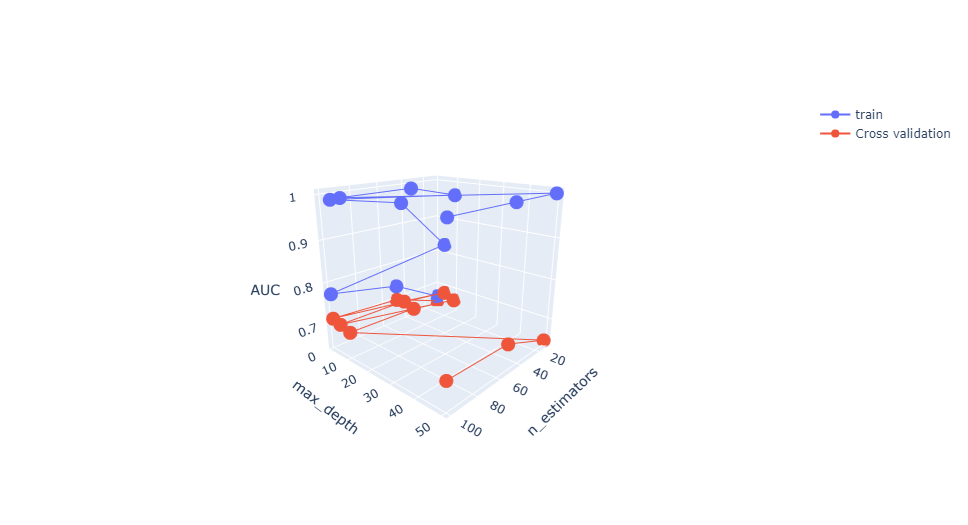

C:\Users\Abhishek Chand\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[02:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


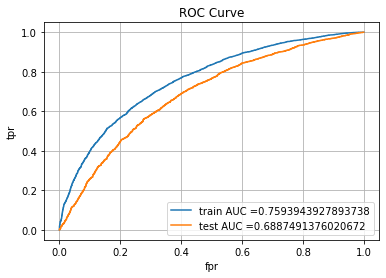

In [115]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

max_depth = clf.best_params_['max_depth']
n_estimators = clf.best_params_['n_estimators']
dt1 = XGBClassifier(max_depth = max_depth,n_estimators = n_estimators)
dt1.fit(X_tr_tfidf, y_train)

y_train_pred = dt1.predict_proba(X_tr_tfidf)
y_test_pred = dt1.predict_proba(X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

auc_test_tfidf = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.grid()
plt.show()

**Confusion Matrix**

In [95]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if (i>=threshold):
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [96]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
train_confusion_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred[:,1], best_t))
print(train_confusion_matrix)
print("Test confusion matrix")
test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred[:,1], best_t))
print(test_confusion_matrix)

the maximum value of tpr*(1-fpr) 0.47922595825426945 for threshold 0.833
Train confusion matrix
[[ 2123   977]
 [ 5104 11896]]
Test confusion matrix
[[ 953  574]
 [2827 5546]]


Text(0.5, 15.0, 'Predicted label')

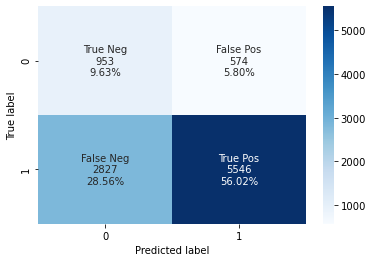

In [97]:
import seaborn as sns
#test_confusion_matrix = np.array(test_confusion_matrix)
#sns.heatmap(test_confusion_matrix, annot=True, fmt="d")

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                test_confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

<h4>GBDT for Feature Set 2</h4>
<h4>Hyperparameter tuning with GridSearchCV</h4>

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {'max_depth':[1, 5, 10, 50],'n_estimators':[10, 50, 100]}
clf2 = GridSearchCV(XGBClassifier(predictor = 'gpu_predictor',tree_method = 'gpu_hist'), params, cv=3, scoring='roc_auc',return_train_score=True, verbose = 2, n_jobs = -1)
clf2.fit(X_tr_tfidf_w2v, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.9min finished
C:\Users\Abhishek Chand\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[01:32:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     predictor='gpu_predictor',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
      

In [106]:
results = pandas.DataFrame.from_dict(clf2.cv_results_)
results = results.sort_values(['param_max_depth'])
#results2 = results.sort_values(['param_min_samples_split'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
test_auc = results['mean_test_score'] 
test_auc_std= results['std_test_score']
depth =  results['param_max_depth']
n_estimators = results['param_n_estimators']

In [107]:
print(clf2.best_estimator_)
print(clf2.best_score_)
#print(clf.best_params_['max_depth'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=1,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method='gpu_hist', validate_parameters=None, verbosity=None)
0.7135473139557122


In [ ]:
import plotly.graph_objects as go
import numpy as np

x1 = n_estimators
y1 = depth
z1 = train_auc

x2 = n_estimators
y2 = depth
z2 = test_auc

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1,trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()

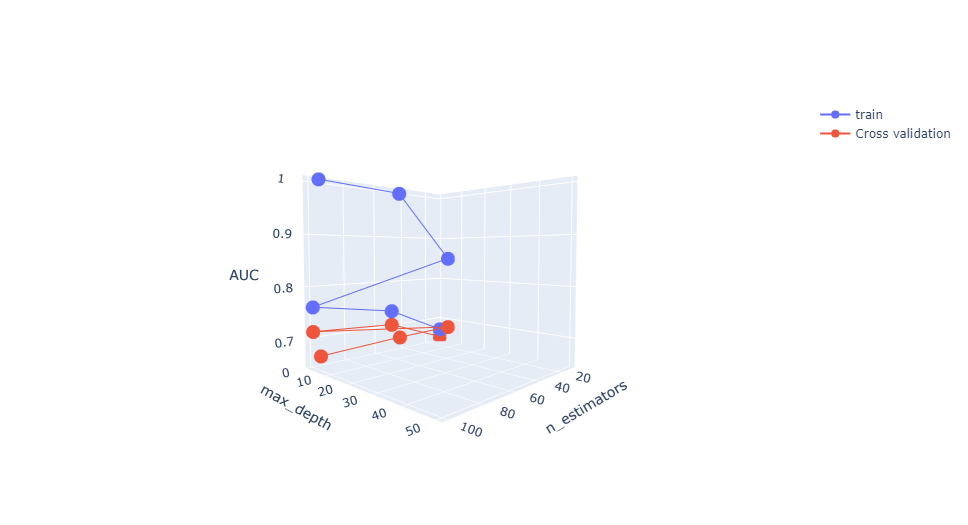

C:\Users\Abhishek Chand\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[02:20:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


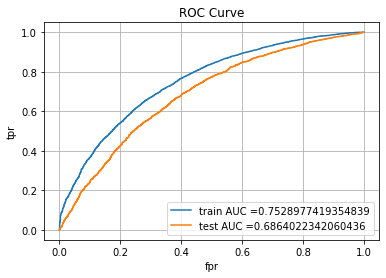

In [114]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

max_depth = clf2.best_params_['max_depth']
n_estimators = clf2.best_params_['n_estimators']
dt2 = XGBClassifier(max_depth = max_depth,n_estimators = n_estimators)
dt2.fit(X_tr_tfidf_w2v, y_train)

y_train_pred = dt2.predict_proba(X_tr_tfidf_w2v)
y_test_pred = dt2.predict_proba(X_te_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

auc_test_tfidf_w2v = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.grid()
plt.show()

**Confusion Matrix**

In [110]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if (i>=threshold):
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [111]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
train_confusion_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred[:,1], best_t))
print(train_confusion_matrix)
print("Test confusion matrix")
test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred[:,1], best_t))
print(test_confusion_matrix)

the maximum value of tpr*(1-fpr) 0.47042554079696386 for threshold 0.839
Train confusion matrix
[[ 2186   914]
 [ 5659 11341]]
Test confusion matrix
[[ 973  554]
 [3027 5346]]


Text(0.5, 15.0, 'Predicted label')

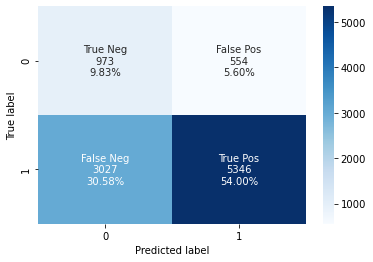

In [112]:
import seaborn as sns
#test_confusion_matrix = np.array(test_confusion_matrix)
#sns.heatmap(test_confusion_matrix, annot=True, fmt="d")

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                test_confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [126]:
print('-'*74)
print('|   Vectorizer   |    Model   |   Hyper parameter  |         AUC         |')
print('-'*74)
print('|      TFIDF     |    GBDT    |      ',clf.best_params_['max_depth'],',',clf.best_params_['n_estimators'], '     | ',auc_test_tfidf,'|')
print('-'*74)
print('|    TFIDF_W2W   |    GBDT    |      ',clf2.best_params_['max_depth'],',',clf2.best_params_['n_estimators'], '     | ',auc_test_tfidf_w2v,'|')

--------------------------------------------------------------------------
|   Vectorizer   |    Model   |   Hyper parameter  |         AUC         |
--------------------------------------------------------------------------
|      TFIDF     |    GBDT    |       1 , 100      |  0.6887491376020672 |
--------------------------------------------------------------------------
|    TFIDF_W2W   |    GBDT    |       1 , 100      |  0.6864022342060436 |
